# Анализ продаж игр

Источник данных: https://www.kaggle.com/datasets/gregorut/videogamesales

Из источника доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы до 2016 года. Необходимо спланировать кампанию на 2017-й год.

**Цель исследования:**
- выявить определяющие успешность игры закономерности, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**Задачи и ход исследования:**
- подготовить данные для работы;
- проанализировать данные;
- определить потенциально прибыльные платформы;
- определить потенциально прибыльные жанры;
- найти зависимость, если есть, между оценками игры и её продажами;
- составить портрет пользователя каждого региона.

# Загрузка датасета и подготовка данных

## Загрузка датасета и просмотр общей информации

Загрузим пакеты и датасет

In [311]:
import os
from statistics import mean
from scipy import stats
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
from pylab import rcParams

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [312]:
BASE_DIR = os.getcwd()

df = pd.read_csv(f'{BASE_DIR}/datasets/games.csv')

Просмотрим общую информацию о датасете

In [313]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [314]:
df.head(10)


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


**Описание данных:**  
    
`Name` - Название игры  
`Platform` - Платформа, на которой вышла игра (например, PC, PS4 и т.д.)  
`Year` - Год выпуска игры  
`Genre` - Жанр игры  
`Publisher` - Издатель игры  
`NA_Sales` - Продажи в Северной Америке (в миллионах)  
`EU_Sales` - Продажи в Европе (в миллионах)  
`JP_Sales` - Продажи в Японии (в миллионах)  
`Other_Sales` - Продажи в остальном мире (в миллионах)  
`Critic_Score` - Оценка критиков  
`User_Score` - Оценка пользователей  
`Rating` - Возрастной рейтинг  

Названия столбцов в датасете не приведены к конвенциональному снейк_кейсу, исправим это.

## Изменение регистра заголовков столбцов

In [315]:
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

## Заполнение пропусков

Проверим в каких столбцах есть пропуски.

In [316]:
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

В датасете достаточно много пропусков, даже есть две строки в которых не указано имя игры, взглянем на них.

In [317]:
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Мы не можем заполнить данные в этих строках, но можем удалить их. Также проверим какую долю от общего объёма данных занимают остальные пропуски.

In [318]:
pd.DataFrame(round(df.isna().mean()*100, 1)).style.background_gradient('coolwarm')


,0
name,0.000000
platform,0.000000
year_of_release,1.600000
genre,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.300000
user_score,40.100000


Помимо пропусков в столбце с именем также можно удалить пропуске в столбце с годом выпуска игр (<5% от общего количества данных).

In [319]:
df = df.dropna(subset=['name', 'year_of_release'])
df.isna().sum()


name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating             6676
dtype: int64

Что касается пропусков в остальных столбцах, мы не можем самостоятельно заполнить данные ни по оценкам критиков и пользователей, ни по рейтингу.  
Оставляем данные как есть.

## Поиск и замена дубликатов

В первую очередь нас интересуют дубликаты в столбце `name`.  
Посмотрим сколько в столбце полных дубликатов.

In [320]:
df['name'].duplicated().sum()


5018

Дубликаты есть и их достаточно много.

In [321]:
df[df['name'].duplicated()].sort_values('name')


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
3862,Frozen: Olaf's Quest,DS,2013.0,Platform,0.21,0.26,0.00,0.04,NaN,NaN,NaN
1785,007: Quantum of Solace,PS3,2008.0,Action,0.43,0.51,0.02,0.19,65.0,6.6,T
14658,007: Quantum of Solace,PC,2008.0,Action,0.01,0.01,0.00,0.00,70.0,6.3,T
3120,007: Quantum of Solace,Wii,2008.0,Action,0.29,0.28,0.01,0.07,54.0,7.5,T
9507,007: Quantum of Solace,DS,2008.0,Action,0.11,0.01,0.00,0.01,65.0,tbd,T
...,...,...,...,...,...,...,...,...,...,...,...
3304,pro evolution soccer 2011,X360,2010.0,Sports,0.09,0.44,0.00,0.07,79.0,5.9,E
4664,pro evolution soccer 2011,PS2,2010.0,Sports,0.04,0.21,0.05,0.11,NaN,6.7,E
2583,pro evolution soccer 2011,PSP,2010.0,Sports,0.05,0.30,0.29,0.16,74.0,5.8,E
12648,pro evolution soccer 2011,PC,2010.0,Sports,0.00,0.05,0.00,0.01,79.0,NaN,NaN


Дубликаты, как мы видим, вызваны тем, что одна игра может выходить на различных платформах. Также было обнаружено, что у игры вышедшей на различных платформах в некоторых случаях может стоять значение в столбце `rating` или быть пропущено. Сделаем допущение, что одна игра на различных платформах имеет один возрастной рейтинг и заполним пропуски.

Проверим дубликаты по двум столбцам `name` и `platfrom`

In [322]:
rating_na = df['rating'].isna().sum()
print(f'До заполнения пропусков в столбце rating {rating_na} пропусков')

До заполнения пропусков в столбце rating 6676 пропусков


Теперь заменим пропуски в рейтингах, там где есть данные по игре на другой платформе.

In [323]:
# создаём копию df без пропусокв в rating
d_filtered = df[~df['rating'].isna()].drop_duplicates('name')

# заменяем пропуски в rating значениями других платформ
mask = df['rating'].isna()
df.loc[mask, 'rating'] = df[mask]['name'].map(d_filtered.set_index('name')['rating'])

Оценим результат заполнения пропусков

In [324]:
df[df['name'].duplicated() == True].sort_values('name')


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
3862,Frozen: Olaf's Quest,DS,2013.0,Platform,0.21,0.26,0.00,0.04,NaN,NaN,NaN
1785,007: Quantum of Solace,PS3,2008.0,Action,0.43,0.51,0.02,0.19,65.0,6.6,T
14658,007: Quantum of Solace,PC,2008.0,Action,0.01,0.01,0.00,0.00,70.0,6.3,T
3120,007: Quantum of Solace,Wii,2008.0,Action,0.29,0.28,0.01,0.07,54.0,7.5,T
9507,007: Quantum of Solace,DS,2008.0,Action,0.11,0.01,0.00,0.01,65.0,tbd,T
...,...,...,...,...,...,...,...,...,...,...,...
3304,pro evolution soccer 2011,X360,2010.0,Sports,0.09,0.44,0.00,0.07,79.0,5.9,E
4664,pro evolution soccer 2011,PS2,2010.0,Sports,0.04,0.21,0.05,0.11,NaN,6.7,E
2583,pro evolution soccer 2011,PSP,2010.0,Sports,0.05,0.30,0.29,0.16,74.0,5.8,E
12648,pro evolution soccer 2011,PC,2010.0,Sports,0.00,0.05,0.00,0.01,79.0,NaN,E


In [325]:
rating_na_new = df['rating'].isna().sum()
print(
    f'Количество пропусков в столбце rating сократилось на {abs(rating_na_new - rating_na)}')
print(f'После заполнения пропусков в столбце rating {rating_na_new} пропусков')


Количество пропусков в столбце rating сократилось на 417
После заполнения пропусков в столбце rating 6259 пропусков


Оставшиеся пропуски в столбце `rating` заполним значением "not_rated". Так как в зависимости от региона рейтинг может и вовсе отсутствовать.

In [326]:
df['rating'] = df['rating'].fillna('not_rated')


Проверка неявных дубликатов

In [327]:
[print(i) for i in sorted(list(df['genre'].unique()))];


Action
Adventure
Fighting
Misc
Platform
Puzzle
Racing
Role-Playing
Shooter
Simulation
Sports
Strategy


In [328]:
[print(i) for i in sorted(list(df['platform'].unique()))];


2600
3DO
3DS
DC
DS
GB
GBA
GC
GEN
GG
N64
NES
NG
PC
PCFX
PS
PS2
PS3
PS4
PSP
PSV
SAT
SCD
SNES
TG16
WS
Wii
WiiU
X360
XB
XOne


In [329]:
[print(i) for i in list(df['rating'].dropna().unique())];

E
not_rated
M
T
E10+
K-A
AO
EC
RP


Неявных дубликатов не выявлено

## Преобразование типов данных

In [330]:
df


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,not_rated
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,not_rated
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,not_rated
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,not_rated
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,not_rated
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,not_rated


In [331]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   object 
 10  rating           16444 non-null  object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Преобразуем тип данных столбцов platform, genre, rating в тип category, т.к. данные в этих стобцах часто повторяются.

In [332]:
df['genre'] = df['genre'].astype('category')
df['rating'] = df['rating'].astype('category')


Тип данных в столбце `user_score` - `object`, хотя столбец содержит вещественные числа, преобразуем  в `float`.  
`'tbd'` (To Be Determined) - намеренный пропуск в данных, заменяем на None

In [333]:
df.loc[df['user_score'] == 'tbd'] = df.loc[df['user_score'] == 'tbd'] = None
df['user_score'] = df['user_score'].astype('float')


In [334]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             14068 non-null  object  
 1   platform         14068 non-null  object  
 2   year_of_release  14068 non-null  float64 
 3   genre            14068 non-null  category
 4   na_sales         14068 non-null  float64 
 5   eu_sales         14068 non-null  float64 
 6   jp_sales         14068 non-null  float64 
 7   other_sales      14068 non-null  float64 
 8   critic_score     6927 non-null   float64 
 9   user_score       7463 non-null   float64 
 10  rating           14068 non-null  category
dtypes: category(2), float64(7), object(2)
memory usage: 1.3+ MB


## Feature engineering

Посчитаем суммарные продажи по всем регионам и запишем их в отдельный солбец.

In [335]:
df['global_sales'] = df[['na_sales', 'eu_sales',
                         'jp_sales', 'other_sales']].sum(axis=1)
df = df.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 11, 8, 9, 10]]
df.head()


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,global_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,82.54,76.0,8.0,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,40.24,NaN,NaN,not_rated
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,35.52,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,32.77,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,31.38,NaN,NaN,not_rated


**В результате подготовки данных** был:  
- изменён регистр заголовков;
- заполнены пропуски в данных, там где это возможно;
- преобразованы типы данных;
- добавлен один столбец.

# EDA

## Посмотрим сколько игр выпускалось в разные годы и важны ли данные за все периоды?

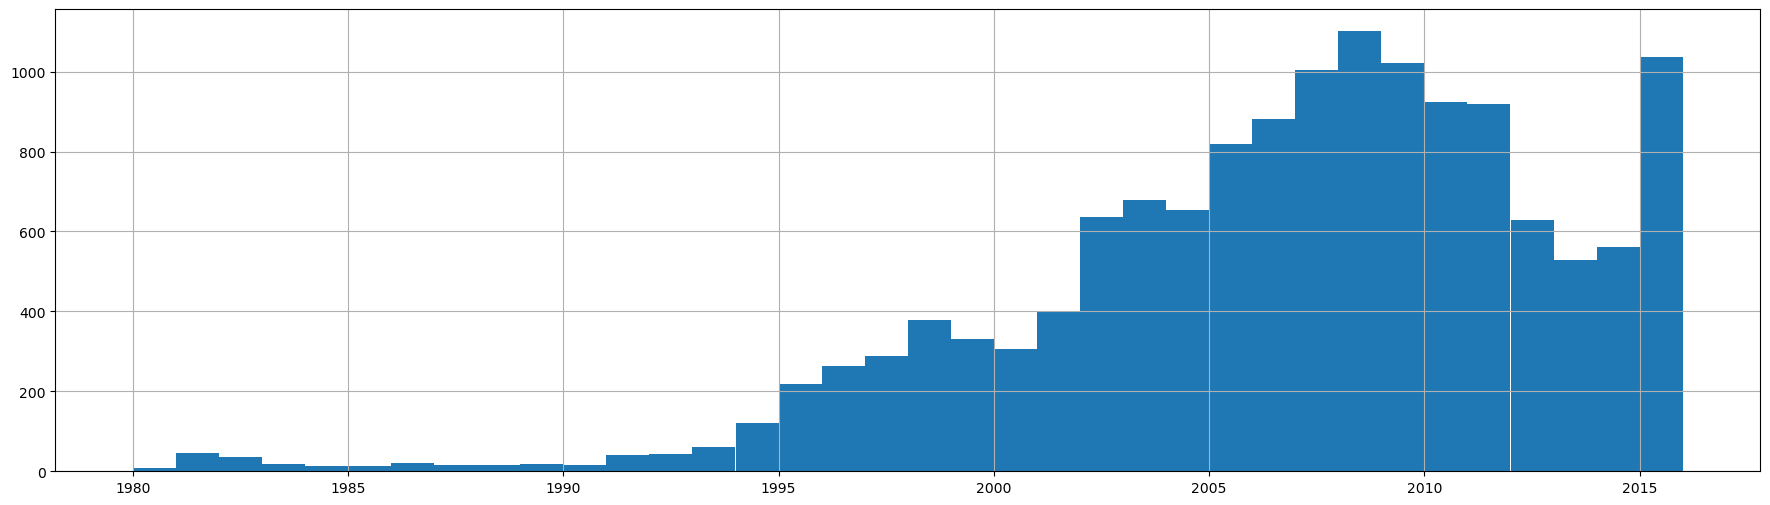

In [336]:
df['year_of_release'].hist(bins=(2016-1980));

Только по гистограме выхода игра не ясно можем ли мы отсечь какие-то данные.  


Посмотрим, как менялись продажи по платформам, и попытаемся определить срок жизни платформы.

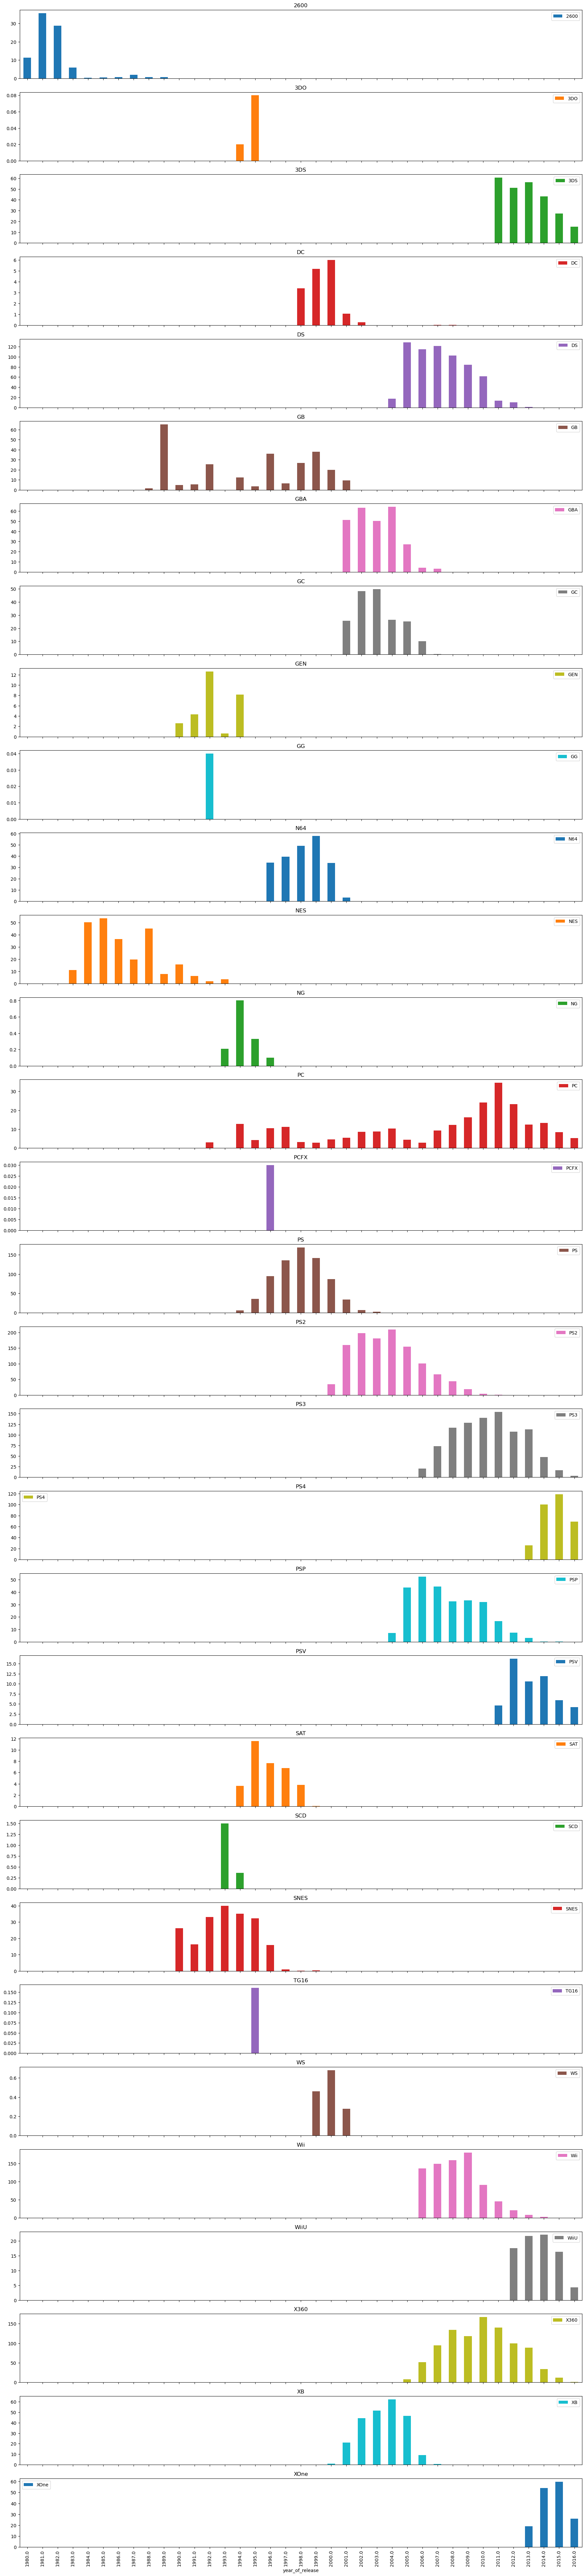

In [337]:
df_by_platform = df.pivot_table(index='year_of_release', columns='platform',
                                values='global_sales', aggfunc=['sum']).reset_index()
df_by_platform.plot.bar(x='year_of_release', y='sum',
                        figsize=(22, 100), subplots=True)
plt.show()


Оценим средний срок жизни отдельной платформы.

In [338]:
platform_lifecycle = []

# в первую очередь сделаем сводную таблицу по платформам с разбивкой продаж игр по годам
df_by_platform = df.pivot_table(
    index='year_of_release', columns='platform', values='global_sales', aggfunc=['sum'])

# пройдём циклом по упорядоченному по продажам списку платформ
for i in list(df.groupby('platform')['global_sales'].sum().sort_values(ascending=False).index):
    if i != 'PC':  # не будем принимать во внимание PC, т.к. это не только игровая платформа
        df_data = df_by_platform['sum', i].fillna(0)
        years_sales_times = []
        for j in df_data.index:
            for k in range(round(df_data[j])):
                years_sales_times.append(j)
        years_sales_times = pd.DataFrame(data={'col1': years_sales_times})

        # многие гистограмы продаж игр на платформах похожи на нормальное распределение
        # будем считать срок жизни платформы по правилу трёх сигм, или по реальным релизам игр если их размах меньше
        p_born = max(years_sales_times['col1'].mean() - years_sales_times['col1'].std()*3, years_sales_times['col1'].min())
        p_death = min(years_sales_times['col1'].mean() + years_sales_times['col1'].std()*3, years_sales_times['col1'].max())

        platform_lifecycle.append([
            i, 
            p_born, 
            p_death if p_death<2016  else '... still alive'
        ])

platform_df = pd.DataFrame(platform_lifecycle, columns=['platform', 'born', 'death'])
platform_df

,platform,born,death
0,PS2,2000.0,2010.0
1,X360,2005.0,... still alive
2,PS3,2006.0,... still alive
3,Wii,2006.0,2013.316511
4,PS,1994.0,2002.886714
5,DS,2004.0,2012.777817
6,PS4,2013.0,... still alive
7,PSP,2004.0,2013.0
8,GBA,2001.0,2007.0
9,GB,1988.0,2001.0


По части платформ данные отсутствуют, часть до сих пор существуют (на момент создания датасета), ни те не другие случаи в рассчёте средней продолжительности жизни платформы не участвуют

In [339]:
platform_df_rel = platform_df[platform_df['death'] != '... still alive']
average_lifecicle = (platform_df_rel['death'] - platform_df_rel['born']).mean()
print(f"Средний жизненный цикл: {average_lifecicle:.2f} лет")

Средний жизненный цикл: 6.74 лет


Многие платформы уже закончили своё существование и данные по ним не понадобятся в дальнейших рассчётах, по некоторым плаформам данные отсутствуют - GG, PCFX и др.  
На данный момент актуальны 7 платформ, по которым мы будем строить прогноз.  
Очистим датасет от излишних данных.

In [340]:
platform_df_rel = platform_df[(platform_df['death'] == '... still alive') & (~platform_df['born'].isna())]

In [341]:
platform_df_rel

,platform,born,death
1,X360,2005.0,... still alive
2,PS3,2006.0,... still alive
6,PS4,2013.0,... still alive
10,3DS,2011.0,... still alive
16,XOne,2013.0,... still alive
18,WiiU,2012.0,... still alive
19,PSV,2011.0,... still alive


In [342]:
# сохраним копию датасета до удаления данных
df_full = df.copy()
df = df[df['platform'].isin(platform_df_rel['platform'])]
df


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,global_sales,critic_score,user_score,rating
14,Kinect Adventures!,X360,2010.0,Misc,15.00,4.89,0.24,1.69,21.82,61.0,6.3,E
16,Grand Theft Auto V,PS3,2013.0,Action,7.02,9.09,0.98,3.96,21.05,97.0,8.2,M
23,Grand Theft Auto V,X360,2013.0,Action,9.66,5.14,0.06,1.41,16.27,97.0,8.1,M
29,Call of Duty: Modern Warfare 3,X360,2011.0,Shooter,9.04,4.24,0.13,1.32,14.73,88.0,3.4,M
31,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,6.03,5.86,0.36,2.38,14.63,NaN,NaN,not_rated
...,...,...,...,...,...,...,...,...,...,...,...,...
16707,Aiyoku no Eustia,PSV,2014.0,Misc,0.00,0.00,0.01,0.00,0.01,NaN,NaN,not_rated
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,0.01,NaN,NaN,not_rated
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,0.01,NaN,NaN,not_rated
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,0.01,NaN,NaN,not_rated


Взглянем на гистограмы продаж по оставшимся платформам.

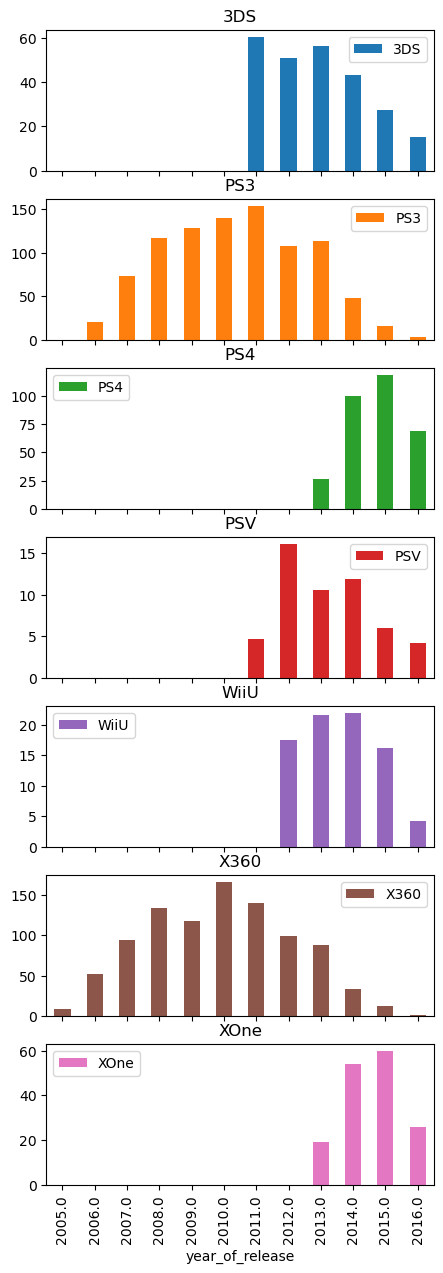

In [343]:
df_by_platform = df.pivot_table(
    index='year_of_release', 
    columns='platform', 
    values='global_sales', 
    aggfunc=['sum']
).reset_index()

df_by_platform.plot.bar(
    x='year_of_release', 
    y='sum', 
    figsize=(5, 15), 
    subplots=True
);


Из оставшихся платформ как минимум на две не стоит делать ставку, это `PS3` и `X360`. Обе платформы доживают последние дни и у них уже есть преемники `PS4` и `XOne`.

За начало актуального периода возьмём 2014г, мы будем опираться на данные за последние 3 года.

In [344]:
df_from_2014 = df.copy()
df_from_2014 = df[df['year_of_release'] >= 2014]


## Определим какие платформы лидируют по продажам, растут или падают.

Платформы которые однозначно падают по продажам:
 - PS3
 - X360  
 
Платформы которые показывают рост:
 - PS4
 - XOne    

Остальные платформы не столь однозначны, но исключать их не стоит, в частности PC


## Оценим глобальную продажу игр в разбивке по платформам.

In [345]:
df_from_2014


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,global_sales,critic_score,user_score,rating
31,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,6.03,5.86,0.36,2.38,14.63,NaN,NaN,not_rated
42,Grand Theft Auto V,PS4,2014.0,Action,3.96,6.31,0.38,1.97,12.62,97.0,8.3,M
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014.0,Role-Playing,4.35,3.49,3.10,0.74,11.68,NaN,NaN,not_rated
77,FIFA 16,PS4,2015.0,Sports,1.12,6.12,0.06,1.28,8.58,82.0,4.3,E
87,Star Wars Battlefront (2015),PS4,2015.0,Shooter,2.99,3.49,0.22,1.28,7.98,NaN,NaN,not_rated
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,0.01,NaN,NaN,not_rated
16707,Aiyoku no Eustia,PSV,2014.0,Misc,0.00,0.00,0.01,0.00,0.01,NaN,NaN,not_rated
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,0.01,NaN,NaN,not_rated
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,0.01,NaN,NaN,not_rated


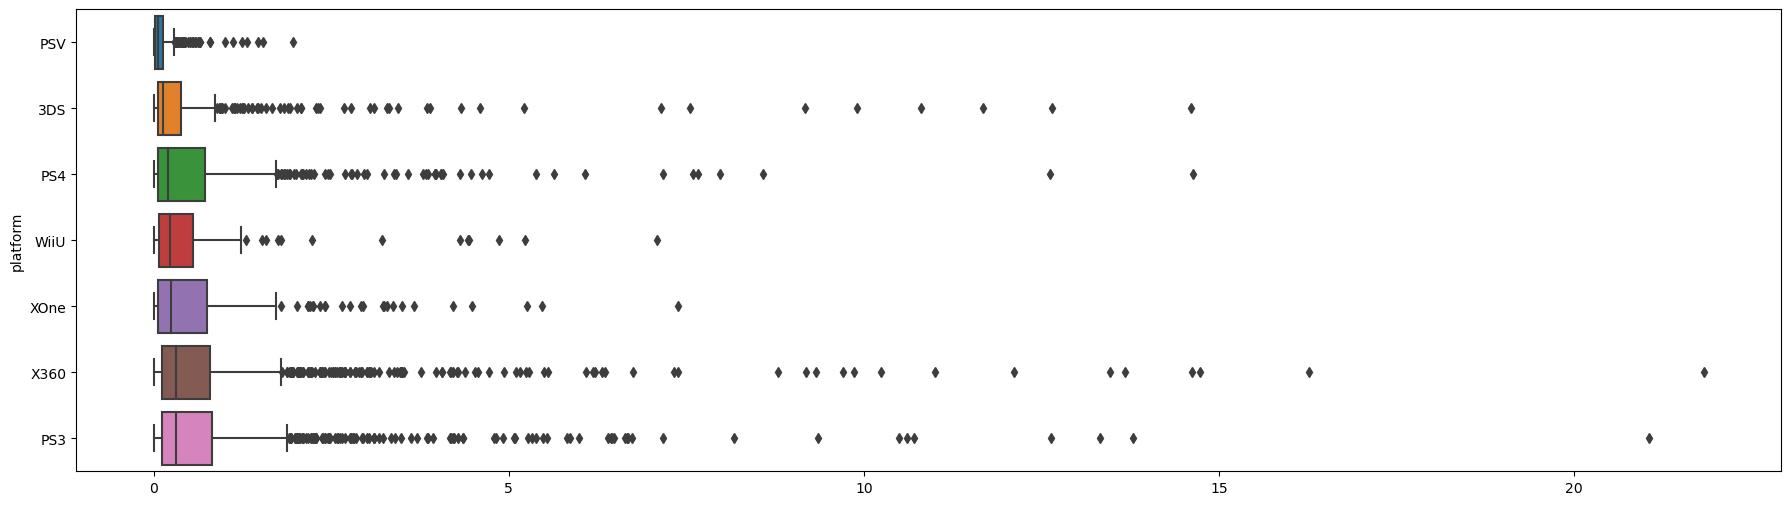

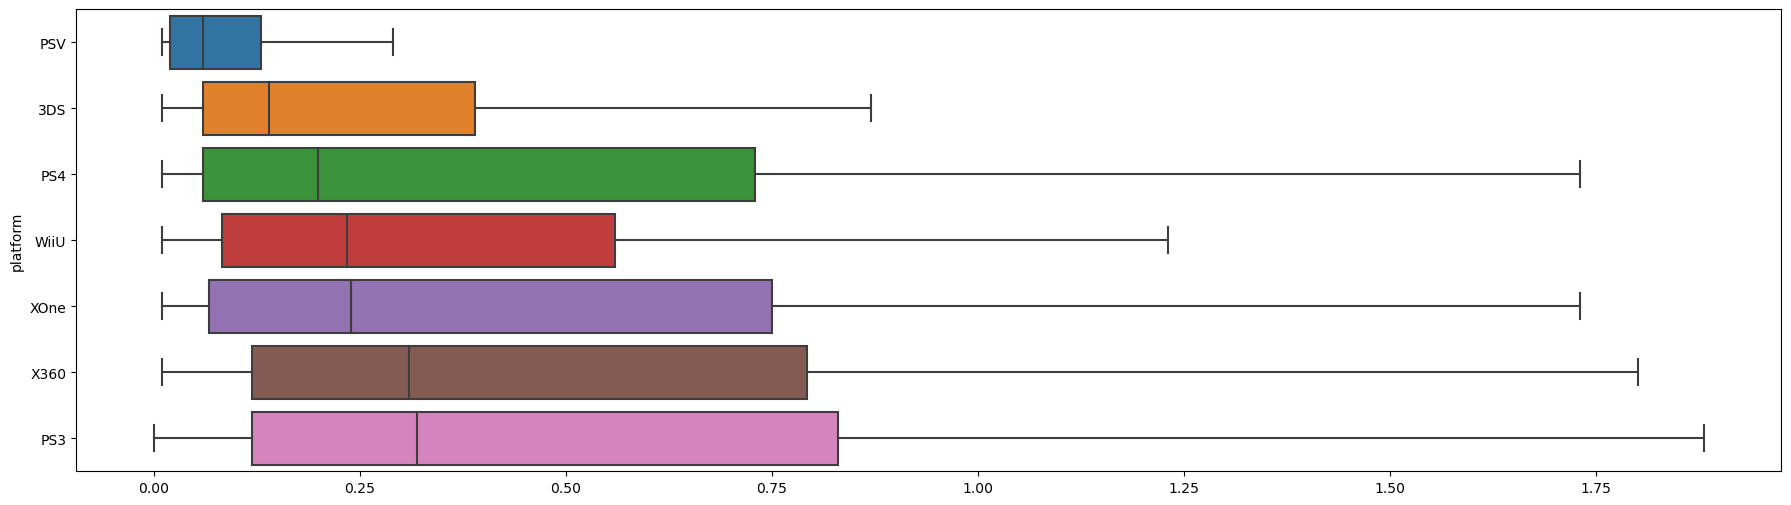

In [346]:
rcParams['figure.figsize'] = 22, 6

df_boxplot = df.pivot_table(
    index='name', columns='platform', values='global_sales').reset_index()
index_sort = list(df_boxplot.median().sort_values().index)
sns.boxplot(data=df_boxplot, orient='h', order=index_sort)
plt.show();
sns.boxplot(data=df_boxplot, orient='h', showfliers=False, order=index_sort);


Самые высокие показатели у `PS3` и `X360`, что вновь говорит в пользу того, что в будущем стоит ориентироваться на продажи `PS4` и `XOne`, как приемников лидирующих ранее платформ. 

**На основе проведённого анализа можно сделать следующие выводы:**  
Самые перспективные платформы: `XOne`, `PS4`  
Платформа, которая вероятно не покажет высоких результатов, но точно не уйдёт с рынка: `PC`  
Платформы продажи которых идут на спад: `3DS`, `PSV`, `WiiU`  
Платформы которые в скором времени уйдут с рынка: `PS3`, `X360`

In [347]:
df = df_from_2014
del df_from_2014

## Посмотрим как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.

Оценим корреляцию между продажами и оценками критиков и пользователей на PS4

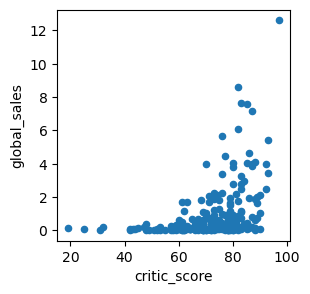

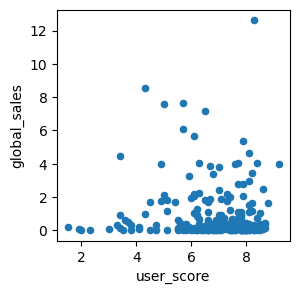

In [348]:
df[df['platform'] == 'PS4'].plot.scatter(
    x='critic_score', y='global_sales', figsize=(3, 3))
plt.show();
df[df['platform'] == 'PS4'].plot.scatter(
    x='user_score', y='global_sales', figsize=(3, 3));


In [349]:
print('Корреляция между оценками критиков и продажами игр на PS4 =  ',
      df[df['platform'] == 'PS4']['critic_score'].corr(df[df['platform'] == 'PS4']['global_sales']))
print('Корреляция между оценками пользователей и продажами игр на PS4 =  ',
      df[df['platform'] == 'PS4']['user_score'].corr(df[df['platform'] == 'PS4']['global_sales']))


Корреляция между оценками критиков и продажами игр на PS4 =   0.40249779652369794
Корреляция между оценками пользователей и продажами игр на PS4 =   -0.04013158947269733


Между оценками критиков и продажами, есть корреляция, но не между оценками пользователей и продажами.

Соотнесите выводы с продажами игр на других платформах.

In [350]:
for i in df['platform'].unique():
    crit_corr = df[df['platform'] == i]['critic_score'].corr(df[df['platform'] == i]['global_sales'])
    user_score = df[df['platform'] == i]['user_score'].corr(df[df['platform'] == i]['global_sales'])
    print(f'Корреляция между оценками критиков и продажами на {i} =  {crit_corr}')
    print(f'Корреляция между оценками пользователей и продажами на {i} =  {user_score}')
    print('\n')


Корреляция между оценками критиков и продажами на PS4 =  0.40249779652369794
Корреляция между оценками пользователей и продажами на PS4 =  -0.04013158947269733


Корреляция между оценками критиков и продажами на 3DS =  0.28468579095782925
Корреляция между оценками пользователей и продажами на 3DS =  0.2151932718527028


Корреляция между оценками критиков и продажами на XOne =  0.424101429462753
Корреляция между оценками пользователей и продажами на XOne =  -0.07038392806475818


Корреляция между оценками критиков и продажами на WiiU =  0.37564022183899803
Корреляция между оценками пользователей и продажами на WiiU =  0.40792645792170795


Корреляция между оценками критиков и продажами на PS3 =  0.44657460493190715
Корреляция между оценками пользователей и продажами на PS3 =  -0.1667614134766211


Корреляция между оценками критиков и продажами на X360 =  0.5257228356581521
Корреляция между оценками пользователей и продажами на X360 =  -0.1384445709456651


Корреляция между оценками крит

На остальных платформах однозначно есть корреляция между оценками критиков и продажами, но не между оценками игроков и продажами.

In [351]:
print(df['user_score'].corr(df['global_sales']))
print(df_full['user_score'].corr(df_full['global_sales']))

-0.02564825746899643
0.08798399271321644


И в случае с полной выборкой, и в случае с отфильтроваными данными корреляция между оценками пользователей и продажами практически отсутствует.

## Оценим продажи по жанрам игр

In [352]:
df.groupby('genre')['name'].count().sort_values(ascending=False)

genre
Action          535
Role-Playing    203
Adventure       165
Sports          138
Shooter         102
Misc             95
Fighting         56
Racing           53
Platform         33
Simulation       23
Strategy         20
Puzzle           10
Name: name, dtype: int64

Больше всего игр в жанре `Action`, меньше всего `Puzzle`

In [353]:
genre_median_dict = {}
for i in df['genre'].unique():
    genre_median = df[df['genre'] == i]['global_sales'].median()
    genre_median_dict[i] = round(genre_median, 3)
[print(f'Медиана продаж по жанру {i[0]} = {i[1]}') for i in sorted(genre_median_dict.items(), key=lambda x: x[1], reverse=True)];

Медиана продаж по жанру Shooter = 0.71
Медиана продаж по жанру Sports = 0.345
Медиана продаж по жанру Platform = 0.15
Медиана продаж по жанру Fighting = 0.13
Медиана продаж по жанру Racing = 0.13
Медиана продаж по жанру Role-Playing = 0.11
Медиана продаж по жанру Misc = 0.11
Медиана продаж по жанру Action = 0.1
Медиана продаж по жанру Simulation = 0.1
Медиана продаж по жанру Strategy = 0.06
Медиана продаж по жанру Puzzle = 0.055
Медиана продаж по жанру Adventure = 0.03


Лучше всего продаются игры жанра `Shooter`, хуже всего `Adventure`

**В результате исследовательского анализа** данных было выявлено, что между оценками критиков и продажами игр есть корреляция, а между оценками пользователей и продажами она практически отсутствует.  
Были выявлены наиболее и наименее перспективные по продажам платформы на 2017 год.  
Также были выявлены наиболее и наименее продаваемые жанры игр.

# Составим портрет пользователя каждого региона

## Определим для пользователя каждого региона топ-5 платформ.

In [354]:
print('NA top 5', df.groupby('platform')[
      'na_sales'].sum().sort_values(ascending=False)[:5], end='\n\n')
print('EU top 5', df.groupby('platform')[
      'eu_sales'].sum().sort_values(ascending=False)[:5], end='\n\n')
print('JP top 5', df.groupby('platform')[
      'jp_sales'].sum().sort_values(ascending=False)[:5], end='\n\n')


NA top 5 platform
PS4     98.49
XOne    80.92
X360    27.54
3DS     22.23
PS3     21.82
Name: na_sales, dtype: float64

EU top 5 platform
PS4     130.04
XOne     46.09
PS3      24.97
3DS      15.42
X360     15.01
Name: eu_sales, dtype: float64

JP top 5 platform
3DS     44.13
PS4     15.02
PSV     14.43
PS3     10.85
WiiU     7.31
Name: jp_sales, dtype: float64



В различных регионах популярны различные платформы.  
В Северной Америке более популярны `X360`.  

В Европе, в отличие от Северной Америки более популярны `PC`.   

В Японии, в топ 5 не попал ни `XBox`, ни `PC`, в топ вошли только платформы местного производства. Первое место у `Nintendo 3DS`. Также в топ 5 попал `WiiU`.

## Определим топ-5 жанров для пользователя каждого региона 

In [355]:
print('NA top 5', df.groupby('genre')['na_sales'].median(
).sort_values(ascending=False)[:5], end='\n\n')
print('EU top 5', df.groupby('genre')['eu_sales'].median(
).sort_values(ascending=False)[:5], end='\n\n')
print('JP top 5', df.groupby('genre')['jp_sales'].median(
).sort_values(ascending=False)[:5], end='\n\n')


NA top 5 genre
Shooter     0.350
Sports      0.095
Platform    0.080
Fighting    0.050
Racing      0.040
Name: na_sales, dtype: float64

EU top 5 genre
Shooter     0.265
Racing      0.080
Platform    0.060
Sports      0.060
Action      0.020
Name: eu_sales, dtype: float64

JP top 5 genre
Puzzle          0.055
Role-Playing    0.050
Fighting        0.040
Strategy        0.025
Misc            0.020
Name: jp_sales, dtype: float64



В различных регионах популярны различные жанры.  
В Северной Америке в топ 5 попадают игры `Fighting`, а в Европе `Simulation`  
В Японии, в топ 5 попали жанры `Role-Playing`, `Misc`, `Action`, а на первом месте `Puzzle`

## Определим влияет ли рейтинг ESRB на продажи в отдельном регионе

In [356]:
print('NA top 5', df.groupby('rating')['na_sales'].sum().sort_values(ascending=False)[:5], end='\n\n')
print('EU top 5', df.groupby('rating')['eu_sales'].sum().sort_values(ascending=False)[:5], end='\n\n')
print('JP top 5', df.groupby('rating')['jp_sales'].sum().sort_values(ascending=False)[:5], end='\n\n')


NA top 5 rating
M            99.00
not_rated    54.64
E            50.02
T            37.95
E10+         31.06
Name: na_sales, dtype: float64

EU top 5 rating
M            93.49
E            55.05
not_rated    45.28
T            30.98
E10+         23.10
Name: eu_sales, dtype: float64

JP top 5 rating
not_rated    54.20
T            15.77
E             8.98
M             8.55
E10+          4.64
Name: jp_sales, dtype: float64



В различных регионах популярны различные возрастные рейтинги.  
В Северной Америке и Европе различия незначительны, за исключением порядка 2-4 мест.  
Однако в Японии первое место по популярности занимают игры без определённого рейтинга, вероятнее всего выпущенные местными издателями и для местного рынка, поэтому не получившие рейтинга в системе ESRB. На втором месте на рынке Японии игры с рейтингом `T`, в то время как в других рассматриваемых регионах он находится на четвёртом месте со значительным отставанием от лидера, рейтинга `М`.

**В результате исследования данных пользователей каждого региона** было выявлено, что предпочтения жителей Северной Америки, Европы и Японии отличаются и в выборе платформы, и в выборе жанров, и даже в возрастном рейтинге. Причём различия между `eu` и `na` выражены меньше, чем между `jp` и остальными регионами.

## Сравним играм на какой платформе Xbox One или PC отдают предпочтения пользователи

В качетсве нулевой гипотезы **H0** возьмём утверждение, что **"средние пользовательские рейтинги платформ Xbox One и PC одинаковые"**, тогда гипотеза **H1 "средние пользовательские рейтинги платформ Xbox One и PC разные"**.  
В качестве проверки гипотезы применим метод t_test к двум выборкам по рейтингам платформ и оценим pvalue.  
В качестве порогового значения alpha будет принято значение в 5%

In [357]:
rate_xbox = list(df_full[df_full['platform'] == 'XOne']['user_score'].dropna())
rate_pc = list(df_full[df_full['platform'] == 'PC']['user_score'].dropna())
print(mean(rate_xbox), mean(rate_pc))
user_score_pc_xbox_pvalue = stats.ttest_ind(rate_xbox, rate_pc, equal_var=False).pvalue
print('Гипотеза H0 принята') if user_score_pc_xbox_pvalue > 0.05 else print('Гипотеза H0 отвергнута')
print(f'Pvalue = {user_score_pc_xbox_pvalue:f}')


6.521428571428571 7.065960264900662
Гипотеза H0 отвергнута
Pvalue = 0.000005


Гипотеза **H0 - "средние пользовательские рейтинги платформ Xbox One и PC одинаковые"** отвергнута.  
Пользовательский рейтиг игр на pc выше, чем на xbox.

## Сравним пользовательские рейтинги жанров Action и Sports

В качестве гипотезы **H0** будет принято утверждение **"средние пользовательские рейтинги жанров Action и Sports одинаковы."** 
Таким образом если pvalue будет ниже порогового значения, то мы перейдём к гипотезе **H1 о том, что рейтинги разные**.

In [358]:
rate_action = list(df[df['genre'] == 'Action']['user_score'].dropna())
rate_sports = list(df[df['genre'] == 'Sports']['user_score'].dropna())
print(mean(rate_action), mean(rate_sports))
user_score_sports_action_pbalue = stats.ttest_ind(
    rate_action, rate_sports).pvalue
print('Гипотеза H0 принята') if user_score_sports_action_pbalue > 0.05 else print(
    'Гипотеза H0 отвергнута')
print(f'Pvalue = {user_score_sports_action_pbalue:e}')


6.8048689138576774 5.272173913043479
Гипотеза H0 отвергнута
Pvalue = 1.038890e-17


Принята гипотеза **H1 - "Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные."**

**В результате проверки гипотез** было выявлено, что:  
- с высокой вероятностью средние пользовательские рейтинги платформ Xbox One и PC разные;
- с высокой вероятностью cредние пользовательские рейтинги жанров Action и Sports разные.

# Общий вывод



Были выявлены **наиболее перспективные платформы** на 2017 год:
- самые перспективные платформы: `XOne`, `PS4`;  
- платформа, которая вероятно не покажет высоких результатов, но точно не уйдёт с рынка: `PC`;  
- платформы, продажи которых идут на спад, на продажи с которых не стоит сильно рассчитывать: `3DS`, `PSV`, `WiiU`.   
- в Японии имеет смысл сделать больший упор на местные платформы, в том числе на `3DS`.

Также были выявлены **наиболее продаваемые жанры игр**:  

Shooter  
Sports  
Platform  
Racing  

Также к списку следует добавить в Северной Америке `Fighting`,   
в Европе `Simulation`.  

Сильно отличается топ 5 в Японии: `Puzzle`, `Role-Playing`, `Fighting`, `Misc`, `Action`  

Был проведён **анализ продаж в зависимости от рейтинга ESRB** в результате которого выявлено, что в четвёрку наиболее популярных рейтингов входят `M`, `E`, `T`. Однако в Японии на первом месте игры без рейтинга, что вероятнее всего указывает на то, что в Японии стоит сделать упор на игры местного производства. Также игры без рейтинга занимают 2-3 места в Северной Америке и Европе соответственно.

В результате исследования данных пользователей по регионам было выявлено, что предпочтения жителей Северной Америки, Европы и Японии отличаются и в выборе платформы, и в выборе жанров, и даже в возрастном рейтинге. Причём различия между `eu` и `na` выражены меньше, чем между `jp` и остальными регионами. В японии следует сделать упор на платформы и игры местного производства.  

На этапе исследовательского анализа данных было выявлено, что **между оценками критиков и продажами игр есть корреляция**, а между оценками пользователей и продажами она скорее отсутствует. При планировании кампании имеет смысл ориентроваться на оценки критиков.  

В результате проверки гипотез выявлено, что:  
- средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- cредние пользовательские рейтинги жанров Action и Sports разные.